In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)

import os
from pathlib import Path
import pickle

import numpy as np
from ase.io import read
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.basis import Basis
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.projector import expand
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import expand_coupling, remove_pbc, rotate_couplings

# BTM

In [3]:
leads_se = np.load("./output/lowdin/self_energy.npy", allow_pickle=True)
energies = np.arange(0, 0.01, 0.01)
se_left = np.array([leads_se[0].retarded(e) for e in energies])
se_right = np.array([leads_se[1].retarded(e) for e in energies])

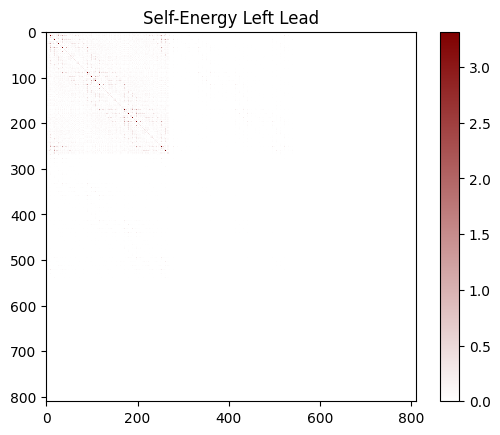

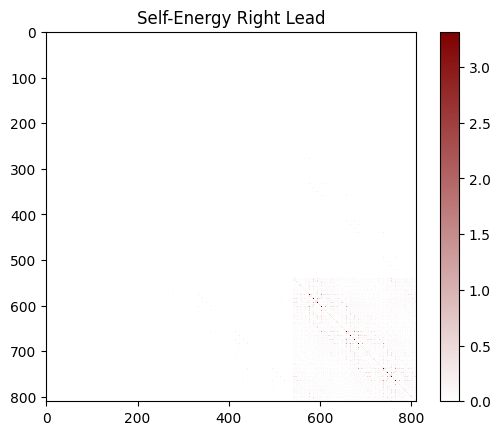

In [4]:
plt.imshow(np.abs(se_left[0]).real, cmap=maroon_cmap, interpolation='nearest')
plt.colorbar()
plt.title('Self-Energy Left Lead')
plt.show()
plt.imshow(np.abs(se_right[0]).real, cmap=maroon_cmap, interpolation='nearest')
plt.colorbar()
plt.title('Self-Energy Right Lead')
plt.show()

# Non-BTM

In [5]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_device, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))

pl_path = Path("./dft/leads/")
cc_path = Path("./dft/device/")
output_folder = "./output/lowdin/dmft/non_spin/vertex_tests"
os.makedirs(output_folder, exist_ok=True)

data_folder = "./output/lowdin"
dmft_data_folder = "./output/lowdin/dmft/non_spin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
dmft_sigma_file = f"{dmft_data_folder}/self_energy.npy"

H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")
H_subdiagonalized, S_subdiagonalized = map(
    lambda m: m.astype(complex),
    np.load("./output/lowdin/hs_los_lowdin.npy"),
)

basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}

leads_atom = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atom, basis_dict)

device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

eta = 1e-3

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao,
    S_leads_lcao,
    unit_cell_rep_in_leads,
    align=(0, H_subdiagonalized[0, 0, 0]),
)

remove_pbc(device_basis, H_subdiagonalized)
remove_pbc(device_basis, S_subdiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id="right"
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# expand to dimension of scattering
expand_coupling(self_energy[0], len(H_subdiagonalized[0]))
expand_coupling(self_energy[1], len(H_subdiagonalized[0]), id="right")

In [6]:
se_left = np.array([self_energy[0].retarded(e) for e in energies])
se_right = np.array([self_energy[1].retarded(e) for e in energies])

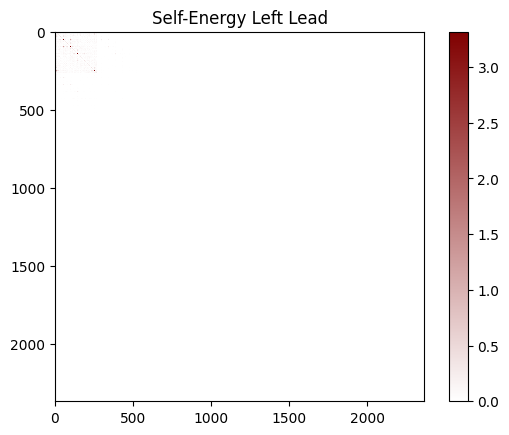

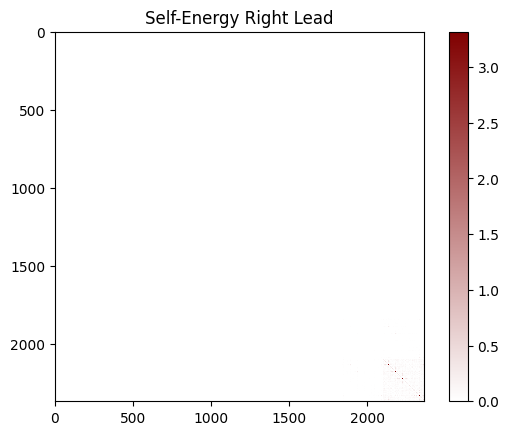

In [7]:
plt.imshow(np.abs(se_left[0]).real, cmap=maroon_cmap, interpolation='nearest')
plt.colorbar()
plt.title('Self-Energy Left Lead')
plt.show()
plt.imshow(np.abs(se_right[0]).real, cmap=maroon_cmap, interpolation='nearest')
plt.colorbar()
plt.title('Self-Energy Right Lead')
plt.show()

In [8]:
dmft_se = np.load("./output/lowdin/dmft/non_spin/self_energy.npy")
dmft_se.shape

(12000, 7, 7)

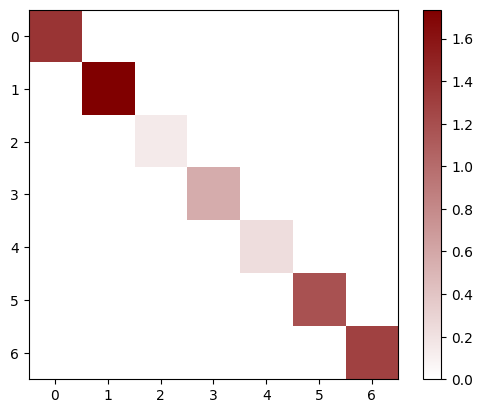

In [9]:
plt.imshow(np.abs(dmft_se[100]).real, cmap=maroon_cmap, interpolation='nearest')
plt.colorbar()


In [10]:
gf = GreenFunction(
    H_subdiagonalized[0],
    S_subdiagonalized[0],
    selfenergies=[(slice(None), self_energy[0]), (slice(None), self_energy[1])],
    eta=eta,
)

# Add the DMFT self-energy for transmission
if comm.rank == 0:
    dmft_sigma = load(dmft_sigma_file)
else:
    dmft_sigma = None

# Transmission function calculation
# S_device = np.eye(len(H_subdiagonalized[0]))
S_device = S_subdiagonalized[0]
idx_molecule = index_active_region

dmft_sigma = comm.bcast(dmft_sigma, root=0)

self_energy[2] = dmft_sigma

gf.selfenergies.append((slice(None), self_energy[2]))

In [12]:
dmft_self_energy = np.array([self_energy[0].retarded(e) for e in energies])

In [13]:
dmft_self_energy.shape

(1, 2368, 2368)